In [1]:
from re import S
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Carga de datos

In [3]:
df = pd.read_csv('close_normalized_prices_index.csv')
# df['X'] = df['X'].apply(lambda x: np.fromstring(x.strip("[]"), sep=' '))
df['Y'] = df['Y'].apply(lambda x: np.fromstring(x.strip("[]"), sep=' '))

In [4]:
df['X'] = df['X'].apply(lambda x:np.fromstring(x.replace('[', '').replace(']', '').replace('\n', ' '), sep=' ').reshape(14, 28))

# Division train-test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(np.stack(df.X.to_numpy()).astype(np.float32),
                                                    np.stack(df.Y.to_numpy()).astype(np.float32),
                                                    test_size=0.25,
                                                    random_state=42)

# Conversión a tensores

In [6]:
X_train = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 14, 28)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32).reshape(-1, 14, 28)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Dataloaders

In [7]:
# Crear DataLoaders
batch_size = 100
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Modelo

In [9]:
class CNN_LSTM(nn.Module):

  def __init__(self):
    super(CNN_LSTM, self).__init__()
    # Capa Conv1D para extracción de características espaciales
    self.conv1 = nn.Conv1d(in_channels=14, out_channels=64, kernel_size=5, padding=1)
    self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=1)
    self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, padding=1)

    # Batch normalization
    self.bn1 = nn.BatchNorm1d(64)
    self.bn2 = nn.BatchNorm1d(128)
    self.bn3 = nn.BatchNorm1d(256)

    # Max Pool
    self.pool = nn.MaxPool1d(kernel_size=2)

    # Dropout
    self.dropout_layer = nn.Dropout(p=0.15)

    # ReLu
    self.relu = nn.ReLU()

    # Capa LSTM
    self.lstm = nn.LSTM(input_size=256, hidden_size=64, num_layers=3, batch_first=True)

    # Capa Fully Connected
    self.fc0_1 = nn.Linear(64, 128)
    self.fc0_2 = nn.Linear(128, 128)
    self.fc0_3 = nn.Linear(128, 128)
    self.fc0_4 = nn.Linear(128, 64)
    self.fc1 = nn.Linear(64, 32) 
    self.fc2 = nn.Linear(32, 16)  
    self.fc3 = nn.Linear(16, 5)  

    # Inicialización de pesos
    self._initialize_weights()

  def _initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
          nn.init.zeros_(m.bias)

  def forward(self, x, embeddings=False):
    # Primer capa completa
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool(x)

    # Segunda capa completa
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.pool(x)

    # Tercera capa completa
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.relu(x)
    x = self.pool(x)

    # Reordenar datos
    # Antes batch, channels, seq_length
    x = x.permute(0, 2, 1)
    # Después batch, seq_length, features

    if embeddings:
      return x

    # Capas LSTM
    x, _ = self.lstm(x)

    # Se toma la ultima salida de secuencia, que es la representación de la serie
    x = x[:, -1, :]

    # Capas Fully Connected
    x = self.dropout_layer(x)
    x = self.fc0_1(x)
    x = self.relu(x)

    x = self.dropout_layer(x)
    x = self.fc0_2(x)
    x = self.relu(x)

    x = self.dropout_layer(x)
    x = self.fc0_3(x)
    x = self.relu(x)

    x = self.dropout_layer(x)
    x = self.fc0_4(x)
    x = self.relu(x)

    x = self.dropout_layer(x)
    x = self.fc1(x)
    x = self.relu(x)

    x = self.dropout_layer(x)
    x = self.fc2(x)
    x = self.relu(x)

    x = self.dropout_layer(x)
    x = self.fc3(x)

    return x

# Función de perdida propia

In [10]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, y_pred, y_true):
        mse = torch.mean(((y_pred - y_true)*100) ** 2)
        return mse

# Train model

Epoch 1/300, Loss: 1169.754935, 34.201680
Epoch 2/300, Loss: 1043.834594, 32.308429
Epoch 3/300, Loss: 1018.684442, 31.916836
Epoch 4/300, Loss: 997.609039, 31.584950
Epoch 5/300, Loss: 979.183891, 31.291914
Epoch 6/300, Loss: 960.752230, 30.996003
Epoch 7/300, Loss: 942.378494, 30.698184
Epoch 8/300, Loss: 923.702423, 30.392473
Epoch 9/300, Loss: 904.676815, 30.077846
Epoch 10/300, Loss: 888.629704, 29.809893
Epoch 11/300, Loss: 871.027024, 29.513167
Epoch 12/300, Loss: 857.169332, 29.277454
Epoch 13/300, Loss: 845.211052, 29.072514
Epoch 14/300, Loss: 827.088827, 28.759152
Epoch 15/300, Loss: 814.584367, 28.540924
Epoch 16/300, Loss: 802.024891, 28.320044
Epoch 17/300, Loss: 791.867185, 28.140135
Epoch 18/300, Loss: 777.437569, 27.882567
Epoch 19/300, Loss: 768.532172, 27.722413
Epoch 20/300, Loss: 756.487671, 27.504321
Epoch 21/300, Loss: 745.136506, 27.297189
Epoch 22/300, Loss: 738.386128, 27.173261
Epoch 23/300, Loss: 729.196731, 27.003643
Epoch 24/300, Loss: 719.448453, 26.82253

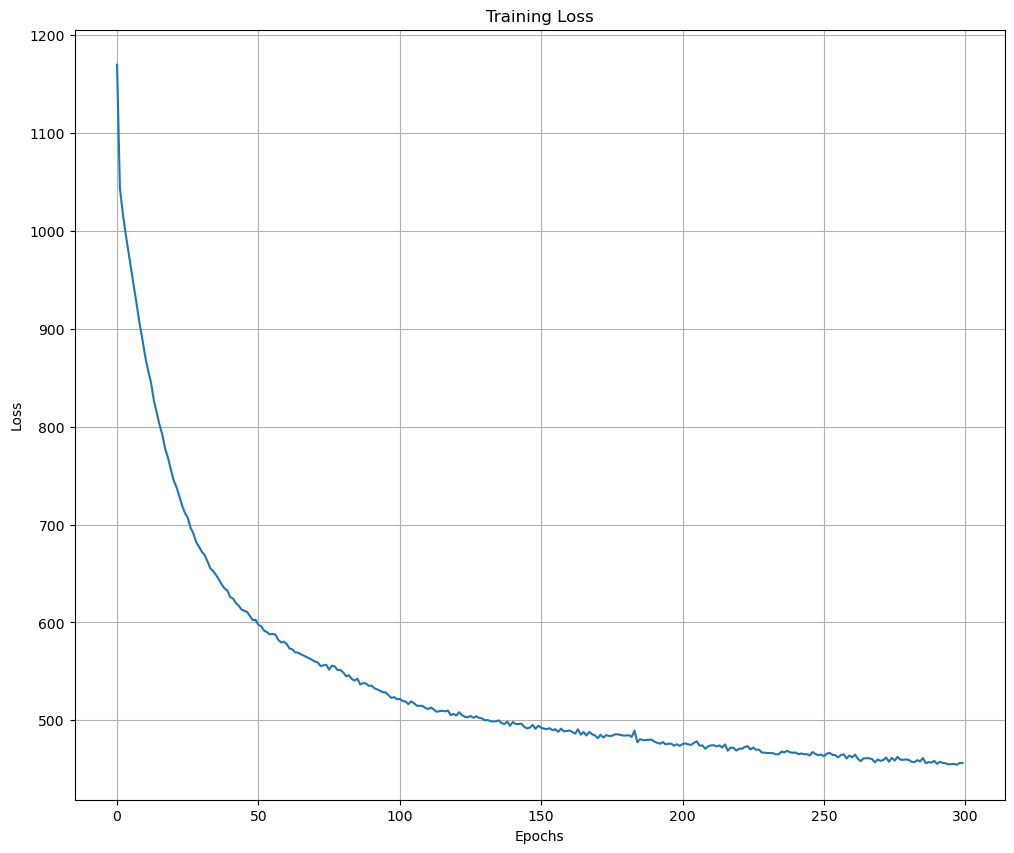

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM().to(device)
criterion = CustomLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
epochs = 300
losses = list()
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        train_loss = total_loss / len(train_loader)
    losses.append(train_loss)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.6f}, {math.sqrt(train_loss):.6f}")

plt.figure(figsize=(12, 10))
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

In [23]:
model.eval()
predictions = []
actuals = []

# Score en test
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)

        predictions.append(y_pred.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

# Convertir listas en arrays
predictions_test = np.concatenate(predictions).reshape(-1, 5)
actuals_test = np.concatenate(actuals).reshape(-1, 5)

# Score en train
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)

        predictions.append(y_pred.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

# Convertir listas en arrays
predictions_train = np.concatenate(predictions).reshape(-1, 5)
actuals_train = np.concatenate(actuals).reshape(-1, 5)

In [24]:
print("Evaluación del modelo:")
print("MAE Train:", np.mean(np.abs(predictions_train - actuals_train)),
      "MAE Test:", np.mean(np.abs(predictions_test - actuals_test)))
print("MSE Train:", np.mean((predictions_train - actuals_train) ** 2),
      "MSE Test:", np.mean((predictions_test - actuals_test) ** 2))
print("RMSE Train:", np.sqrt(np.mean((predictions_train - actuals_train) ** 2)),
      "RMSE Test:", np.sqrt(np.mean((predictions_test - actuals_test) ** 2)))

Evaluación del modelo:
MAE Train: 0.17625958 MAE Test: 0.2132043
MSE Train: 0.061992794 MSE Test: 0.096304424
RMSE Train: 0.24898352 RMSE Test: 0.31032953


**V4 eval (20 epochs)**

Evaluación del modelo:

MAE Train: 0.19669463 MAE Test: 0.2098076

MSE Train: 0.078998394 MSE Test: 0.094072245

RMSE Train: 0.28106654 RMSE Test: 0.306712

**V3 eval (50 epochs)**

Evaluación del modelo:

MAE Train: 0.19468875 MAE Test: 0.21950419

MSE Train: 0.07334924 MSE Test: 0.09926174

RMSE Train: 0.27083063 RMSE Test: 0.31505832

**V3 eval (300 epochs)**

MAE Train: 0.17625958 MAE Test: 0.2132043

MSE Train: 0.061992794 MSE Test: 0.096304424

RMSE Train: 0.24898352 RMSE Test: 0.31032953

In [25]:
torch.save(model.state_dict(), "../weights/cnn_lstm_index_v4_weights_3.pth")
torch.save(model, "../models/cnn_lstm_index_v4_model_3.pth")